# IAM Lines dataset

### Large Writer Independent Text Line Recognition Task
```
This task consists of a total number of 9'862 text lines. It provides one training, one testing, and two validation sets. The text lines of all data sets are mutually exclusive, thus each writer has contributed to one set only.

Set Name	Number of Text Lines	Number of Writers
Train	6'161	283
Validation 1	900	46
Validation 2	940	43
Test	1'861	128
Total	9'862	500
```

In [1]:
import os
import string
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
_DATA_DIRNAME = '../../handwriting_recognition/data/iam'
!ls {_DATA_DIRNAME}

forms  label_by_line_id.json  lines  LWITLR_task  xml


In [3]:
def read_image(image_uri, grayscale=True):
    """
    Read image_uri.
    """
    def read_image_from_filename(image_filename, grayscale):
        imread_flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
        return cv2.imread(image_filename, imread_flag)

    def read_image_from_url(image_url, grayscale):
        url_response = urlopen(image_url)
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        imread_flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
        return cv2.imdecode(img_array, imread_flag)

    local_file = os.path.exists(image_uri)
    try:
        img = None
        if local_file:
            img = read_image_from_filename(image_uri, grayscale)
        else:
            img = read_image_from_url(image_uri, grayscale)
    except Exception as e:
        raise ValueError("Could not load image at {}: {}".format(image_uri, e))
    return img

def resize(image, scale_factor):
    """
    Resize image.
    OpenCV does not resize in place, hence need to copy and return in case
    scale_factor is 1 to maintain consistency in behaviour
    """
    if scale_factor == 1:
        return image.copy()
    return cv2.resize(
        image,
        dsize=None,
        fx=scale_factor,
        fy=scale_factor,
        interpolation=cv2.INTER_AREA
    )

In [4]:
emnist_essentials_filename = '../text_recognizer/datasets/emnist_essentials.json'

def _augment_emnist_mapping(mapping):
    """Augment the mapping with extra symbols."""
    # symbols in IAM dataset
    extra_symbols = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?']

    # padding symbol
    extra_symbols.append('_')

    max_key = max(mapping.keys())
    extra_mapping = {}
    for i, symbol in enumerate(extra_symbols):
        extra_mapping[max_key + 1 + i] = symbol

    return {**mapping, **extra_mapping}



with open(emnist_essentials_filename) as f:
    essentials = json.load(f)
int_to_char_mapping_dict = _augment_emnist_mapping(dict(essentials['mapping']))
assert len(int_to_char_mapping_dict.values()) == len(set(int_to_char_mapping_dict.values()))
int_to_char_mapping_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'c',
 39: 'd',
 40: 'e',
 41: 'f',
 42: 'g',
 43: 'h',
 44: 'i',
 45: 'j',
 46: 'k',
 47: 'l',
 48: 'm',
 49: 'n',
 50: 'o',
 51: 'p',
 52: 'q',
 53: 'r',
 54: 's',
 55: 't',
 56: 'u',
 57: 'v',
 58: 'w',
 59: 'x',
 60: 'y',
 61: 'z',
 62: ' ',
 63: '!',
 64: '"',
 65: '#',
 66: '&',
 67: "'",
 68: '(',
 69: ')',
 70: '*',
 71: '+',
 72: ',',
 73: '-',
 74: '.',
 75: '/',
 76: ':',
 77: ';',
 78: '?',
 79: '_'}

In [5]:
char_to_int_mapping_dict = {v:k for k, v in int_to_char_mapping_dict.items()}
char_to_int_mapping_dict

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35,
 'a': 36,
 'b': 37,
 'c': 38,
 'd': 39,
 'e': 40,
 'f': 41,
 'g': 42,
 'h': 43,
 'i': 44,
 'j': 45,
 'k': 46,
 'l': 47,
 'm': 48,
 'n': 49,
 'o': 50,
 'p': 51,
 'q': 52,
 'r': 53,
 's': 54,
 't': 55,
 'u': 56,
 'v': 57,
 'w': 58,
 'x': 59,
 'y': 60,
 'z': 61,
 ' ': 62,
 '!': 63,
 '"': 64,
 '#': 65,
 '&': 66,
 "'": 67,
 '(': 68,
 ')': 69,
 '*': 70,
 '+': 71,
 ',': 72,
 '-': 73,
 '.': 74,
 '/': 75,
 ':': 76,
 ';': 77,
 '?': 78,
 '_': 79}

In [6]:
def get_iam_labels(label_file):
    with open(label_file, 'r') as f:
        labels_dict = json.load(f)
    return labels_dict


def get_line_id_from_filename(filename):
    """
    Input example: '../data/iam/words_5/g06-031e-02-00.png' or '../data/iam/words_5/g06-031e-02.png'
    Output example: 'g06-031e-02'  (line_id)
    """
    return '-'.join(os.path.splitext(os.path.basename(filename))[0].split('-')[:3])


def iam_helper(image_directory, label_dict, label_to_int_mapping, image_height):
    """Create an IAM dataset object from IAM-DB images
    Args:
        buckets: a sorted list of integers describing image widths of all buckets
        label_dict: a dictionary with key being image id and value being its label
    """
    dirname = os.path.join(_DATA_DIRNAME, 'LWITLR_task')
    train_index_path = os.path.join(dirname, 'trainset.txt')
    val_index_path = os.path.join(dirname, 'validationset2.txt')
    test_index_path = os.path.join(dirname, 'testset.txt')

    assert os.path.exists(train_index_path) and os.path.exists(val_index_path) and os.path.exists(test_index_path)

    def load_iam_lines(index_path):
        with open(index_path, 'r') as f:
            image_filenames = f.read().splitlines()
        image_filenames = [os.path.join(image_directory, '{}.png'.format(fname)) for fname in image_filenames]
        return load(image_filenames, get_line_id_from_filename)

    def load_image(image_filename):
        image = read_image(image_filename, grayscale=True)
        image = 255. - image
        image = resize(image, (image_height / image.shape[0]))
#         image = image / 255.
        return image
        
    def load(image_filenames, get_label_key_func):
        images = [load_image(fname) for fname in image_filenames]
        labels = [label_dict[get_label_key_func(filename)] for filename in image_filenames]
        return images, labels  #int_labels

    x_train, y_train = load_iam_lines(train_index_path)
    x_val, y_val = load_iam_lines(val_index_path)
    x_test, y_test = load_iam_lines(test_index_path)

    print(f'Number of images in train: {len(x_train)}')
    print(f'Number of images in val: {len(x_val)}')
    print(f'Number of images in test: {len(x_test)}')

    return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
image_height = 28
image_directory = os.path.join(_DATA_DIRNAME, 'lines')
label_by_line_id = get_iam_labels(os.path.join(_DATA_DIRNAME, 'label_by_line_id.json'))

assert os.path.exists(image_directory)

x_train, y_train, x_val, y_val, x_test, y_test = iam_helper(
    image_directory=image_directory,
    label_dict=label_by_line_id,
    label_to_int_mapping=None,
    image_height=image_height
)

Number of images in train: 6161
Number of images in val: 940
Number of images in test: 1861


In [8]:
### check if images and labels match

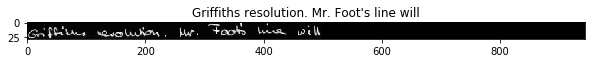

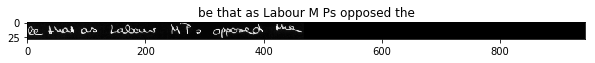

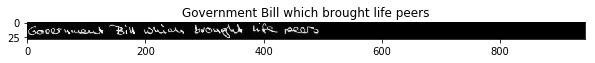

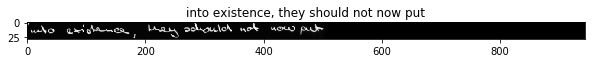

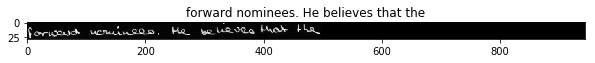

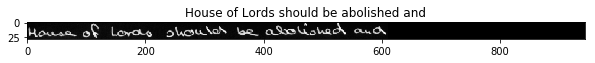

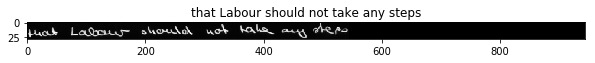

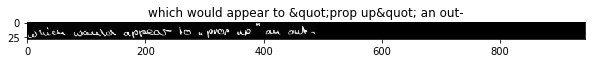

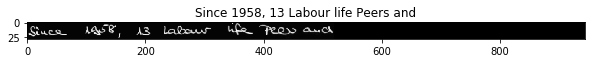

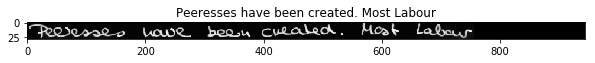

In [15]:
for i in range(10, 20):
    plt.figure(figsize=(10, 10))
    plt.title(y_train[i])
    plt.imshow(x_train[i], cmap='gray')

## Some processing before storing as h5
 - combine train and val
 - pad images to same length

### combining `train` and `val`

In [10]:
x_train.extend(x_val)
y_train.extend(y_val)
print(f'Number of images in train: {len(x_train)}')

Number of images in train: 7101


### pad all images to constant width

In [11]:
max_image_width = np.max([img.shape[1] for img in x_train + x_test])
print(f'Pad all images to width: {max_image_width}')

Pad all images to width: 944


In [14]:
x_train = np.stack([
    np.pad(img, ((0, 0), (0, max_image_width - img.shape[1])), mode='constant', constant_values=0)
    for img in x_train
]).astype(np.uint8)
x_test = np.stack([
    np.pad(img, ((0, 0), (0, max_image_width - img.shape[1])), mode='constant', constant_values=0)
    for img in x_test
]).astype(np.uint8)

x_train.shape, x_test.shape

((7101, 28, 944), (1861, 28, 944))

### convert labels to int labels

In [24]:
y_train_char = y_train.copy()
y_test_char = y_test.copy()

In [25]:
y_train = [[char_to_int_mapping_dict[char] for char in sentence] for sentence in y_train]
y_test = [[char_to_int_mapping_dict[char] for char in sentence] for sentence in y_test]

### pad all labels to constant length and convert to int

In [26]:
max_label_width = np.max([len(lbl) for lbl in y_train + y_test])
print(f'Pad all labels to length: {max_label_width}')

Pad all labels to length: 97


In [29]:
pad_integer = max(int_to_char_mapping_dict.keys())
pad_character = int_to_char_mapping_dict[pad_integer]
pad_character, pad_integer

('_', 79)

In [33]:
y_train = np.stack([
    np.pad(lbl, (0, max_label_width - len(lbl)), mode='constant', constant_values=pad_integer)
    for lbl in y_train
]).astype(np.uint8)

y_test = np.stack([
    np.pad(lbl, (0, max_label_width - len(lbl)), mode='constant', constant_values=pad_integer)
    for lbl in y_test
]).astype(np.uint8)

y_train.shape, y_test.shape

((7101, 97), (1861, 97))

### save as h5

In [34]:
processed_dirname = '../data/processed/iam_lines'
os.mkdir(processed_dirname)

In [35]:
import h5py
processed_iam_filename = f'{processed_dirname}/lwitlrt.h5'

with h5py.File(processed_iam_filename, 'w') as f:
    f.create_dataset('x_train', data=x_train, dtype='u1', compression='lzf')
    f.create_dataset('y_train', data=y_train, dtype='u1', compression='lzf')
    f.create_dataset('x_test', data=x_test, dtype='u1', compression='lzf')
    f.create_dataset('y_test', data=y_test, dtype='u1', compression='lzf')

/home/saurabh/.local/share/virtualenvs/pandagrader-KaJ4nncx/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Verfication of saved h5

In [36]:
with h5py.File(processed_iam_filename) as f:
    x_train_saved = f['x_train'][:]
    y_train_saved = f['y_train'][:]
    x_test_saved = f['x_test'][:]
    y_test_saved = f['y_test'][:]

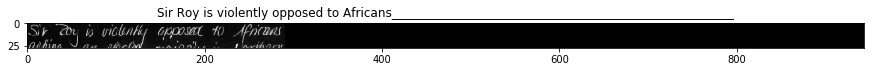

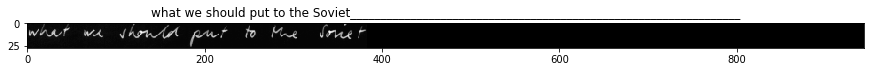

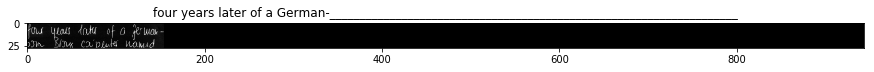

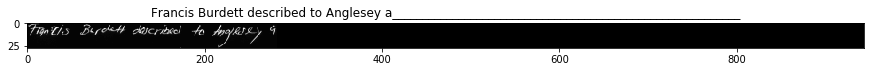

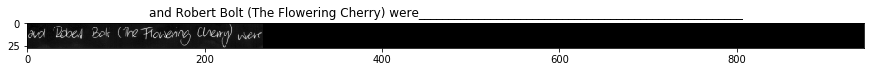

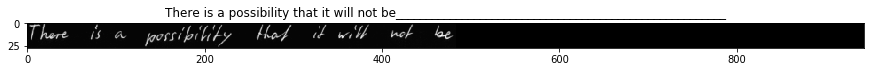

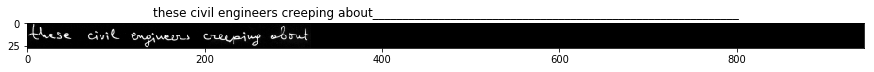

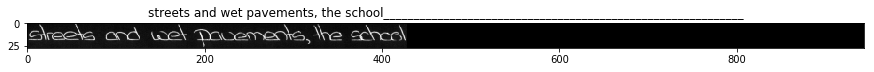

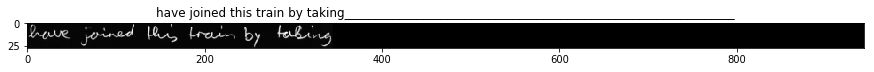

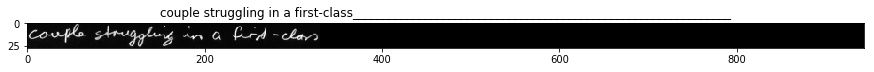

In [40]:
for index in np.random.randint(0, high=x_train_saved.shape[0], size=10):
    plt.figure(figsize=(15, 15))
    plt.title(''.join([int_to_char_mapping_dict[int_char] for int_char in y_train_saved[index]]))
    plt.imshow(x_train_saved[index], cmap='gray')

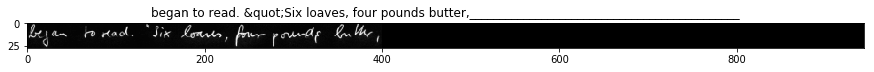

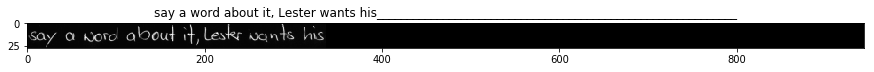

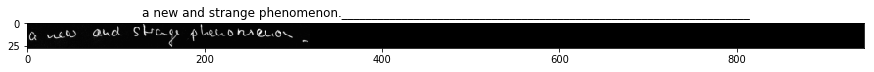

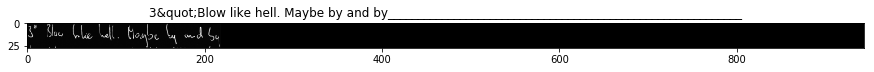

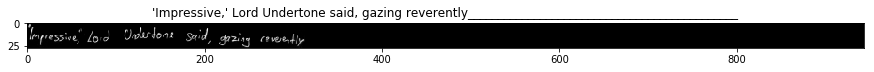

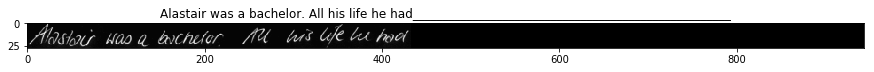

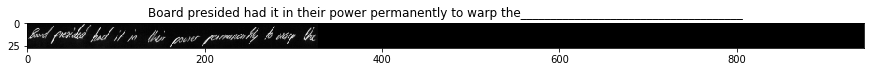

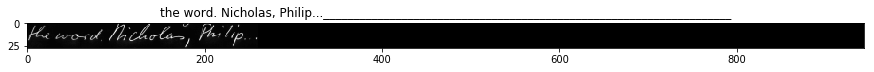

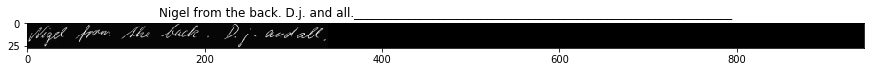

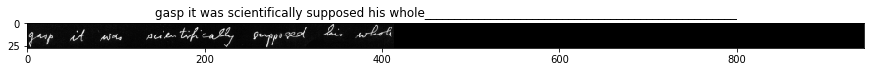

In [41]:
for index in np.random.randint(0, high=x_test_saved.shape[0], size=10):
    plt.figure(figsize=(15, 15))
    plt.title(''.join([int_to_char_mapping_dict[int_char] for int_char in y_test_saved[index]]))
    plt.imshow(x_test_saved[index], cmap='gray')